<a href="https://colab.research.google.com/github/jinayou/abmcore/blob/main/ABMcore_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2023.12.04

-Trading preference formula: Dirichlet
- Spreading preference:
    - Create new (num_opinion_groups) trading preferences using Dirichlet
- Redistribution:
    - Does NOT redistribute preferences when opinion groups converge
    - Does NOT use determine_distributed_earnings


In [ ]:
pip install mesa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.1/241.1 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
pip install powerlaw

In [ ]:
import mesa
import math
import random
import numpy as np
import copy

In [ ]:
class TraderAgent(mesa.Agent):

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model) # Pass the parameters to the parent class.
        self.trading_preference = self.dirichlet_trading_preference()
        self.latest_trading_decision = 0
        self.earnings = 0
        self.historical_earnings = [] # program not set up yet

    ## Trading prefrence formulas ##
    def dirichlet_trading_preference(self):
        return np.random.dirichlet(np.ones((3,), dtype=int), size=1)[0].tolist() # Choose 3 random nums that add up to 1

    # Generate trading decisions based on probabilities
    def trade(self):
        decision = random.choices([1, -1, 0], weights=self.trading_preference, k=1)[0]
        #1=buy, -1=sell, 0=hold
        return decision

    def step(self):
        self.latest_trading_decision = self.trade()
        # self.historical_earnings.append(self.find_latest_earnings())

        # print(f"Agent {self.unique_id}'s trading preferences: {self.trading_preference}")
        # print(f"Agent {self.unique_id}'s trading decision: {self.latest_trading_decision}")

In [ ]:
class TradingModel(mesa.Model):

    def __init__(self, N, omega, sensitivity):
        self.num_agents = N
        self.schedule = mesa.time.RandomActivation(self)
        self.data_collector = mesa.datacollection.DataCollector(
            agent_reporters={"Latest Trading Decision": "latest_trading_decision"},
            model_reporters={"Traders' Decisions": "agent_decisions", "Returns": "returns_list"}
        )
        self.returns_list = []
        self.earnings_list = []
        self.latest_return = sum(agent.latest_trading_decision for agent in self.schedule.agents)*sensitivity
        self.current_step=1

       # Add the agent to the scheduler
        for i in range(self.num_agents):
            self.schedule.add(TraderAgent(i, self))

    ## Trading prefrence formulas ##
    def dirichlet_trading_preference(self):
        return np.random.dirichlet(np.ones((3,), dtype=int), size=1)[0].tolist() # Choose 3 random nums that add up to 1


    ## EARNINGS ##
    def determine_earnings(self):
        self.earnings_list=[]

        for agent in self.schedule.agents:
            agent.earnings = -self.latest_return*agent.latest_trading_decision
            self.earnings_list.append(agent.earnings)


    ## Preferences ##
    def assign_preferences(self, r):

        #Determine number of opinion groups
        if r != 0:
            num_opinion_groups = int((self.num_agents / (abs(r)))**omega)

        else:
            num_opinion_groups = int(self.num_agents)
        print("New number of opinion groups: ", num_opinion_groups)

        #Find indices of successful agents from last iteration
        self.determine_earnings()
        success_index = []
        for i in range(len(self.earnings_list)):
          if self.earnings_list[i] > 0:
            success_index.append(i)

        success_count = len(success_index)
        random_groups = num_opinion_groups - success_count

        unique_preferences = []
        '''
        #If we have more successful agents than opinion groups, select opinions randomly from successful agents
        if random_groups <=0:
          for i in range(num_opinion_groups):
            choice = random.choice(success_index)
            unique_preferences.append(TraderAgent(choice, self).trading_preference) # so actually this function is flawed and instead of choosing winning strategies, it creates new strategies
        #Otherwise, select preferences randomly for remaining opinion groups
        else:
            for i in range(success_count):
              choice = random.choice(success_index)
              unique_preferences.append(TraderAgent(choice, self).trading_preference)
            for i in range(random_groups):
                unique_preferences.append(np.random.dirichlet(np.ones((3,), dtype=int), size=1)[0].tolist())
        '''
        for i in range(num_opinion_groups):
            unique_preferences.append(np.random.dirichlet(np.ones((3,), dtype=int), size=1)[0].tolist())


        # Assign agents evenly to the opinion groups
        agents_per_group = len(self.schedule.agents) // num_opinion_groups
        remaining_agents = len(self.schedule.agents) % num_opinion_groups

        agent_index = 0
        for preference in unique_preferences:
            # print(preference)

            if remaining_agents > 0:
                group_size = agents_per_group + 1
            else:
                group_size = agents_per_group

            group_agents = self.schedule.agents[agent_index:agent_index+group_size]
            for agent in group_agents:
                agent.trading_preference = preference
                # print(f"Agent {agent.unique_id} was assigned")
            agent_index += group_size
            remaining_agents -= 1


    def step(self):

        print("------------------------Beginning of step", self.current_step, "------------------------")
        self.current_step+=1

        # Advance the model by one step
        self.assign_preferences(self.latest_return/sensitivity)
        self.schedule.step()
        self.data_collector.collect(self)

        agent_decisions = [agent.latest_trading_decision for agent in self.schedule.agents]
        # print("Traders' Decisions:", agent_decisions)

        # Calculate and store the cumulative trading decisions from all agents
        self.latest_return = sum(agent.latest_trading_decision for agent in self.schedule.agents)*sensitivity
        print("Return:", self.latest_return)
        self.returns_list.append(self.latest_return)
        # print("Historical Returns:", self.returns_list)

        # self.determine_earnings()

In [ ]:
### RUN MODEL ###

## Parameters

#Sensitivity to price change
sensitivity = 1

#Power of omega term
omega = 1 #Check if omega is incorporated correctly

#Trading velocity
V=1.64
Vf=0.4
Vc=(V - 0.83*Vf)/(1- 0.83)
print(Vc)

#Daily trading probability
p=Vc/(250*2)
q=p
#h=1-p-q

## Run

p_hold=0.4

model = TradingModel(1000, omega, sensitivity) #Number of traders
for i in range(3628): #Number of time steps
    model.step()

print("Returns at Each Step:", model.returns_list)

#Test
# print(model.schedule.agents[1].historical_earnings)


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Return: 20
------------------------Beginning of step 1963 ------------------------
New number of opinion groups:  50
Return: -25
------------------------Beginning of step 1964 ------------------------
New number of opinion groups:  40
Return: 64
------------------------Beginning of step 1965 ------------------------
New number of opinion groups:  15
Return: -84
------------------------Beginning of step 1966 ------------------------
New number of opinion groups:  11
Return: -49
------------------------Beginning of step 1967 ------------------------
New number of opinion groups:  20
Return: 187
------------------------Beginning of step 1968 ------------------------
New number of opinion groups:  5
Return: 417
------------------------Beginning of step 1969 ------------------------
New number of opinion groups:  2
Return: -172
------------------------Beginning of step 1970 ------------------------
New number of o

In [ ]:
output_returns = model.returns_list

In [ ]:
### SAVE THE RESULT IN CSV ###

# This is causing error

'''from google.colab import drive
import csv

# Mount Google Drive
drive.mount('/content/drive')

# Define the file path
file_path = "/content/drive/MyDrive/ABMcore/Output/Output_returns.csv"

# Writing to CSV file
with open(file_path, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(output_returns)'''

'from google.colab import drive\nimport csv\n\n# Mount Google Drive\ndrive.mount(\'/content/drive\')\n\n# Define the file path\nfile_path = "/content/drive/MyDrive/ABMcore/Output/Output_returns.csv"\n\n# Writing to CSV file\nwith open(file_path, \'w\', newline=\'\') as csvfile:\n    csv_writer = csv.writer(csvfile)\n    csv_writer.writerow(output_returns)'



ANALYSIS

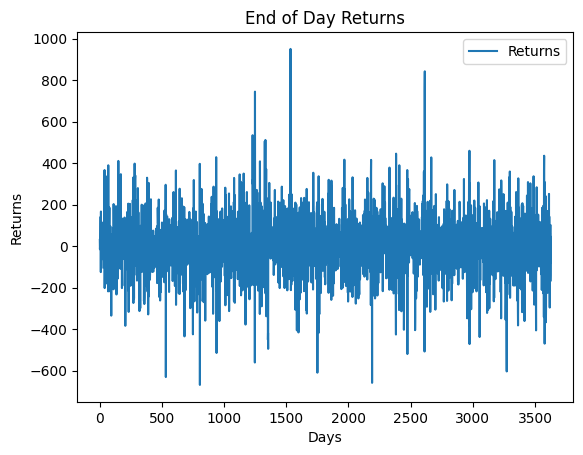

<ipython-input-10-41249c3c793c>:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(output_returns, hist=True, kde=False,


[30, 15, 2, 26, 2, 13, 58, 142, 125, 167, 68, 30, 107, 35, 44, 27, 15, 6, 14, 39, 22, 9, 2, 19, 17, 114, 56, 111, 19, 60, 62, 13, 13, 81, 101, 20, 99, 104, 367, 202, 63, 25, 145, 44, 151, 82, 151, 338, 177, 76, 180, 147, 177, 69, 14, 49, 45, 80, 34, 19, 59, 104, 50, 29, 26, 119, 189, 218, 390, 45, 87, 38, 8, 38, 11, 61, 82, 186, 6, 23, 8, 70, 154, 218, 54, 95, 84, 66, 7, 19, 10, 99, 335, 47, 79, 43, 41, 2, 2, 29, 57, 75, 10, 70, 4, 37, 30, 98, 88, 145, 208, 203, 67, 26, 23, 121, 52, 10, 21, 55, 4, 48, 14, 41, 192, 171, 41, 38, 61, 81, 193, 89, 155, 88, 233, 134, 29, 63, 50, 11, 9, 40, 3, 33, 68, 156, 103, 84, 270, 411, 3, 24, 55, 23, 52, 23, 29, 14, 29, 62, 97, 38, 37, 27, 15, 10, 109, 92, 102, 347, 65, 125, 2, 5, 46, 135, 70, 119, 202, 18, 64, 120, 2, 10, 76, 4, 2, 6, 19, 12, 27, 32, 57, 13, 28, 127, 74, 63, 119, 138, 191, 160, 152, 87, 85, 384, 131, 92, 112, 18, 4, 10, 3, 3, 27, 18, 37, 19, 74, 164, 104, 41, 18, 14, 62, 59, 70, 49, 69, 205, 214, 129, 317, 56, 125, 46, 32, 80, 36, 70,

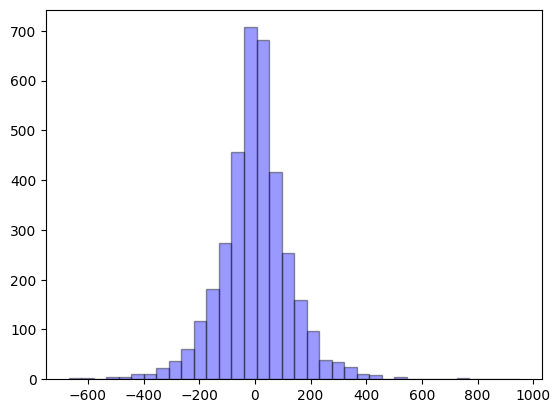

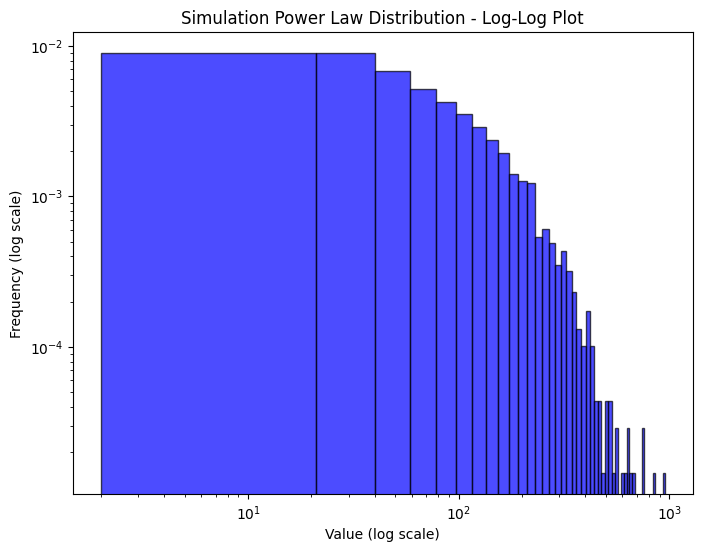

[INFO] computing Hill Estimators...
2

Sample size n: 3628
Total number of exceeded k: 3627


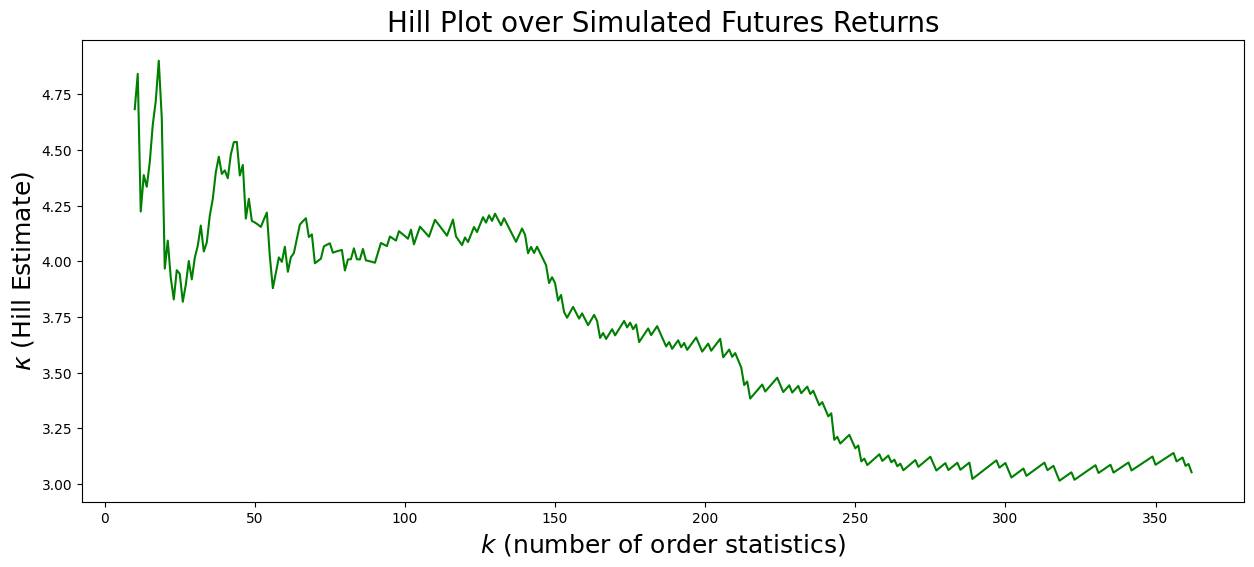

In [ ]:
import matplotlib.pyplot as plt
import powerlaw
import pandas as pd
import seaborn as sns

## PLOT SIMULATION ##

# Plot returns
plt.plot(output_returns, label='Returns')
plt.xlabel('Days')
plt.ylabel('Returns')
plt.title('End of Day Returns')
plt.legend()
plt.show()

# Histogram
sns.distplot(output_returns, hist=True, kde=False,
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

#Option 1
'''data=[]
for i in output_returns:
  data.append(abs(i))
print(data)'''

#Option 2
data=[]
for i in output_returns:
  if abs(i)<2:
    data.append(2)
  else:
    data.append(abs(i))
print(data)

#Option 3
'''data=[]
for i in output_returns:
  if i== 0:
    data.append(0.001)
  else:
    data.append(abs(i))
print(data)'''


# Plot returns on a log-log scale
plt.figure(figsize=(8, 6))
plt.hist(data, bins=50, density=True, alpha=0.7, color='blue', edgecolor = 'black')
plt.xscale('log')
plt.yscale('log')
plt.title('Simulation Power Law Distribution - Log-Log Plot')
plt.xlabel('Value (log scale)')
plt.ylabel('Frequency (log scale)')
plt.show()



### Hill Estimator FOR SIMULATION

# code found on GitHub under the profile AlinaSode

def Hill_estimator(data):
    """
    Returns the Hill Estimators for some 1D data set.
    """
    # sort data in such way that the smallest value is first and the largest value comes last:
    Y = np.sort(data)
    n = len(Y)

    Hill_est = np.zeros(n-1)

    for k in range(0, n-1):    # k = 0,...,n-2
        summ = 0

        for i in range(0,k+1):   # i = 0, ..., k
            summ += np.log(Y[n-1-i]) - np.log(Y[n-2-k])

        Hill_est[k] = (1 / (k+1)) * summ      # add 1 to k because of Python syntax

    kappa = 1. / Hill_est
    return kappa


n_obs = len(data)
k_max = int(round(0.1*n_obs))
k_min = 10

print("[INFO] computing Hill Estimators...")
#t0 = time()
print(min(data))
kap_gains_sim = Hill_estimator(data)

#print ("        done in %0.3f minutes" % ((time() - t0)/60))
print ("")

print ("Sample size n:", n_obs)
print ("Total number of exceeded k:", len(kap_gains_sim))


""" Hill Plot for Gains for k in range (10,...,round(0.1*n_obs)) """

plt.figure(figsize=(15, 6))
plt.plot(np.arange(k_min,k_max), kap_gains_sim[k_min-1:k_max-1], 'green')
plt.xlabel("$k$ (number of order statistics)", fontsize=18)
plt.ylabel("$\kappa$ (Hill Estimate)", fontsize=18)
plt.title("Hill Plot over Simulated Futures Returns", fontsize=20)
plt.show()

            Date  Price   Open   High    Low     Vol. Change % Return
0     12/05/2023  2.748  2.702  2.785  2.678             2.00%   0.02
1     12/04/2023  2.694  2.728  2.752  2.649  161.79K   -4.26%  -0.04
2     12/01/2023  2.814  2.809  2.844  2.754  133.19K    0.43%   0.00
3     11/30/2023  2.802  2.799  2.855  2.761  147.75K   -0.07%   0.00
4     11/29/2023  2.804  2.792   2.87   2.76  141.59K    3.62%   0.04
...          ...    ...    ...    ...    ...      ...      ...    ...
3623  01/08/2010  5.749  5.827  5.853  5.621  101.15K   -0.98%  -0.01
3624  01/07/2010  5.806  6.033  6.108  5.763  135.11K   -3.38%  -0.03
3625  01/06/2010  6.009   5.69  6.075   5.65  140.61K    6.60%   0.07
3626  01/05/2010  5.637  5.837  5.858  5.615   99.49K   -4.20%  -0.04
3627  01/04/2010  5.884  5.705  5.894  5.705   78.86K    5.60%   0.06

[3628 rows x 8 columns]
0       0.0200
1       0.0426
2       0.0043
3       0.0007
4       0.0362
         ...  
3623    0.0098
3624    0.0338
3625    0.0660


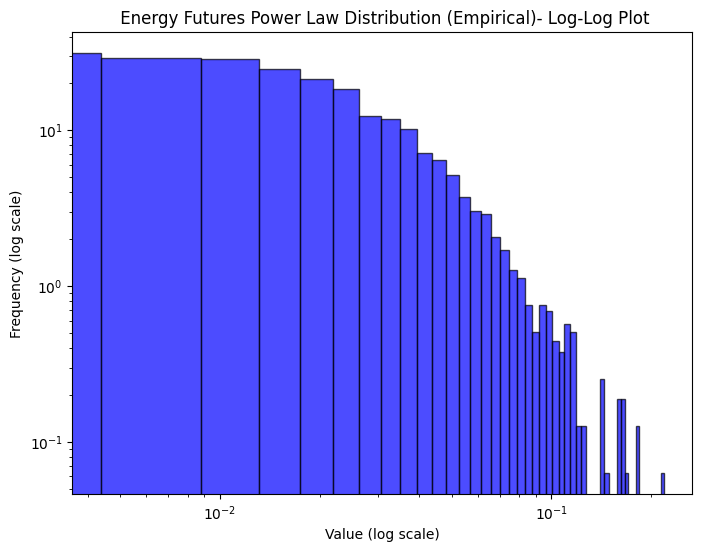

In [ ]:
## READ IN NATURAL GAS FUTURES DATA

## Load data from the drive

from google.colab import auth
auth.authenticate_user()

import gspread

# method 1
from google.auth import default
creds, _ = default()
gc = gspread.authorize(creds)

gsheets = gc.open_by_url('https://docs.google.com/spreadsheets/d/1VMZvoSCBruftaPjW7XwjlsjZBfLdOQ3BKNY2WiC46eE/edit?usp=drive_link')
sheets = gsheets.worksheet('Natural Gas Futures Historical Data').get_all_values()
futures_data = pd.DataFrame(sheets[1:], columns=sheets[0])

# method 2
'''
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)

#Path to the data will likely change for you
path = "/content/drive/MyDrive/ABMcore/Data/Gas_futures_data.gsheet"

futures_data=pd.read_csv(path)
'''

print(futures_data)

futures_data["Change"] = futures_data['Change %'].str.rstrip('%').astype('float') / 100.0
fdata = futures_data["Change"].abs()

print(fdata)

## PLOT NATURAL GAS FUTURES DATA
# Plot the data on a log-log scale
plt.figure(figsize=(8, 6))
plt.hist(fdata, bins=50, density=True, alpha=0.7, color='blue', edgecolor = 'black')
plt.xscale('log')
plt.yscale('log')
plt.title(' Energy Futures Power Law Distribution (Empirical)- Log-Log Plot')
plt.xlabel('Value (log scale)')
plt.ylabel('Frequency (log scale)')
plt.show()


[INFO] computing Hill Estimators...


<ipython-input-10-41249c3c793c>:76: RuntimeWarning: divide by zero encountered in log
  summ += np.log(Y[n-1-i]) - np.log(Y[n-2-k])
<ipython-input-10-41249c3c793c>:76: RuntimeWarning: invalid value encountered in double_scalars
  summ += np.log(Y[n-1-i]) - np.log(Y[n-2-k])



Sample size n: 3628
Total number of exceeded k: 3627


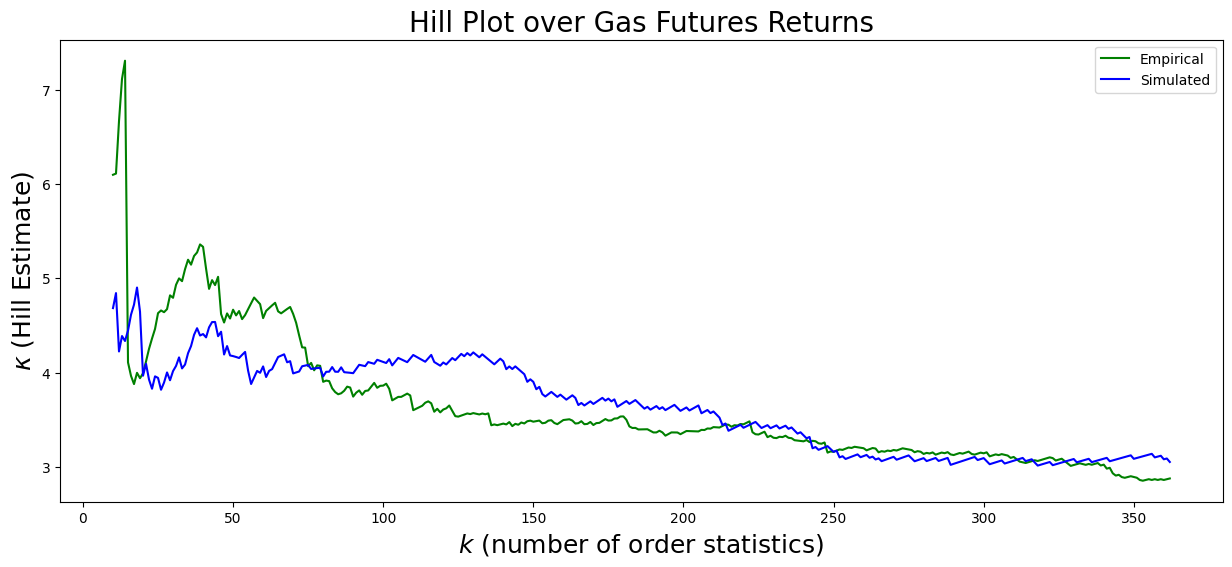

[8.2955124  5.64438234 8.01278687 4.97016531 5.6811414  5.89244124
 6.02926574 5.5874546  5.91816439 4.68324937 4.84224144 4.22367878
 4.38716121 4.33454448 4.4447142  4.61324889 4.72011706 4.90114446
 4.64523732 3.96684797 4.09280256 3.92570077 3.82847493 3.9598927
 3.94354113 3.81786939 3.89405232 4.00117463 3.91853276 4.01566594
 4.07041007 4.16062836 4.0439451  4.08505178 4.20520036 4.2808919
 4.39980556 4.47010512 4.39256187 4.408312   4.3730489  4.47970863
 4.53507481 4.53632848 4.38541822 4.4328794  4.19152194 4.28070326
 4.18150464 4.17431584 4.16519323 4.15425171 4.18742142 4.21887444
 4.02057328 3.87880573 3.94807011 4.0173345  3.99733365 4.06508506
 3.9528197  4.01762002 4.03670732 4.10078204 4.16485676 4.17976334
 4.19346058 4.1088877  4.12084676 3.99097024 4.00163626 4.01128912
 4.06700147 4.0743757  4.08080159 4.03840244 4.04337731 4.0474856
 4.05075106 3.95853775 4.00801947 4.00930044 4.05819435 4.00907822
 4.00819405 4.05534928 4.00385066 4.00099253 3.99751497 3.9934378

In [ ]:
## HILL ESTMATOR FOR GAS FUTURES ##

n_obs = len(fdata)
k_max = int(round(0.1*n_obs))
k_min = 10

print("[INFO] computing Hill Estimators...")
#t0 = time()

kap_gains = Hill_estimator(fdata)


print ("")

print ("Sample size n:", n_obs)
print ("Total number of exceeded k:", len(kap_gains))


""" Hill Plot for Gains for k in range (10,...,round(0.1*n_obs)) """

plt.figure(figsize=(15, 6))
plt.plot(np.arange(k_min,k_max), kap_gains[k_min-1:k_max-1], 'green', label = 'Empirical')
plt.plot(np.arange(k_min,k_max), kap_gains_sim[k_min-1:k_max-1], 'blue', label = 'Simulated')
plt.legend()
plt.xlabel("$k$ (number of order statistics)", fontsize=18)
plt.ylabel("$\kappa$ (Hill Estimate)", fontsize=18)
plt.title("Hill Plot over Gas Futures Returns", fontsize=20)
plt.show()
print(kap_gains_sim[0:100])
print(kap_gains[0:100])
print('kap_gains',kap_gains[72])
print('kap_gains_sim', kap_gains_sim[72])
ratio = []
for i in range(100):
  ratio.append(kap_gains_sim[i]/kap_gains[i])
print(ratio)